# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.221733,False,1.111044
1,-0.211903,False,-0.454795
2,-1.306921,False,-4.290942
3,0.358945,True,6.445438
4,-0.355270,False,-0.711614
...,...,...,...
995,0.494475,True,5.202539
996,0.115104,False,0.106966
997,-1.992502,False,-6.262127
998,-0.628103,False,-2.596068


<AxesSubplot:xlabel='v0'>

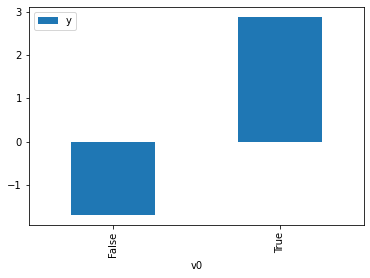

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

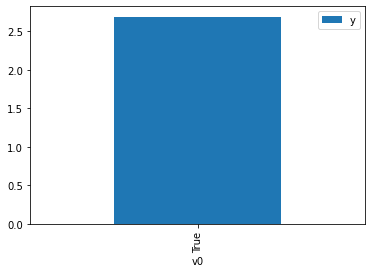

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.742254,False,-1.765183,0.790512,1.265003
1,-1.116457,False,-3.735143,0.876924,1.140350
2,1.192501,False,2.015640,0.123656,8.086974
3,0.303469,False,2.599272,0.389790,2.565485
4,-1.979873,False,-5.724103,0.968634,1.032381
...,...,...,...,...,...
995,-2.376863,False,-5.089368,0.983769,1.016499
996,-1.997735,False,-5.027884,0.969543,1.031414
997,-0.585910,False,-2.527823,0.743160,1.345606
998,-1.125575,False,-2.957637,0.878586,1.138193


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.538773,True,-3.456475,0.012377,80.797277
1,-2.538773,True,-3.456475,0.012377,80.797277
2,-0.204507,True,4.285345,0.397803,2.513804
3,0.009217,True,4.927432,0.487101,2.052961
4,-1.675061,True,-0.381951,0.051542,19.401519
...,...,...,...,...,...
995,0.654555,True,6.099366,0.739723,1.351857
996,-1.695563,True,0.519423,0.049866,20.053610
997,-0.575170,True,2.981730,0.260338,3.841167
998,-1.142837,True,2.779974,0.118321,8.451573


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.005e+04
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        16:23:38   Log-Likelihood:                         -1401.9
No. Observations:                1000   AIC:                                      2808.
Df Residuals:                     998   BIC:                                      2818.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8202      0.026    109.215      0.000       2.769       2.871
x2             4.9452      0.057     86.248      0.000       4.833       5.058
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.495
Skew:                           0.052   Prob(JB):                        0.781
Kurtosis:                       2.970   Cond. No.                         2.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""